In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import files
uploaded=files.upload()
import pandas as pd

df = pd.read_csv('Sleep_health_and_lifestyle_dataset.csv')
df.head()


Saving Sleep_health_and_lifestyle_dataset.csv to Sleep_health_and_lifestyle_dataset (2).csv


,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [ ]:
df.shape
df.head()


,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [ ]:
#data exploration
print("\nDataset Info:")
print(df.info())

print("\nBasic Statistics:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nTarget Variable Distribution:")
print(df['Quality of Sleep'].value_counts())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB
None

B

In [ ]:
#data preprocessing
data=df.copy()
#num_cols
for col in data.select_dtypes(include=['float64', 'int64']).columns:
    if data[col].isnull().sum():
        data[col].fillna(data[col].median(), inplace=True)
#categorial cols
for col in data.select_dtypes(include=['object']).columns:
    if data[col].isnull().sum():
        data[col].fillna(data[col].mode()[0], inplace=True)
#missing values
data.isnull().sum()

,0
Person ID,0
Gender,0
Age,0
Occupation,0
Sleep Duration,0
Quality of Sleep,0
Physical Activity Level,0
Stress Level,0
BMI Category,0
Blood Pressure,0


In [ ]:
#encode categorial values
label_encoders = {}
cat_cols = data.select_dtypes(include=['object']).columns.tolist()
target_col = 'Quality of Sleep'  # remove taget cols from cat cols
if target_col in cat_cols:
    cat_cols.remove(target_col)
    #encode cat cols
for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le
    # Encode target variable if it's categorical
if data[target_col].dtype == 'object':
    target_encoder = LabelEncoder()
    data[target_col] = target_encoder.fit_transform(data[target_col])




In [ ]:
# prepare features and target
# Separate features (X) and target (y)
X = data.drop(target_col, axis=1)
y = data[target_col]

# Encode target variable to be 0-indexed for models like XGBoost
target_encoder = LabelEncoder()
y = target_encoder.fit_transform(y)

X.shape
y.shape
X.columns

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape[0]
X_test.shape[0]
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
#train models
#store models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}
# Dictionary to store results
results = {}
for name, model in models.items():

    print(f"Training {name}")

    # Use scaled data for Logistic Regression, regular data for tree-based models
    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        # Cross-validation
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred
    }

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")#4f means 4 decimal places
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred))



Training Random Forest
Test Accuracy: 0.9600
Cross-Validation Accuracy: 0.9663 (+/- 0.0356)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       0.95      1.00      0.98        21
           3       0.88      0.94      0.91        16
           4       1.00      0.91      0.95        22
           5       1.00      1.00      1.00        14

    accuracy                           0.96        75
   macro avg       0.97      0.97      0.97        75
weighted avg       0.96      0.96      0.96        75

Training XGBoost
Test Accuracy: 1.0000
Cross-Validation Accuracy: 0.9731 (+/- 0.0253)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00        21
           3  

MODEL COMPARISON

               Model  Test Accuracy  CV Accuracy   CV Std
            XGBoost       1.000000     0.973107 0.025308
  Gradient Boosting       0.973333     0.959774 0.022877
      Random Forest       0.960000     0.966328 0.035607
Logistic Regression       0.946667     0.946384 0.016850


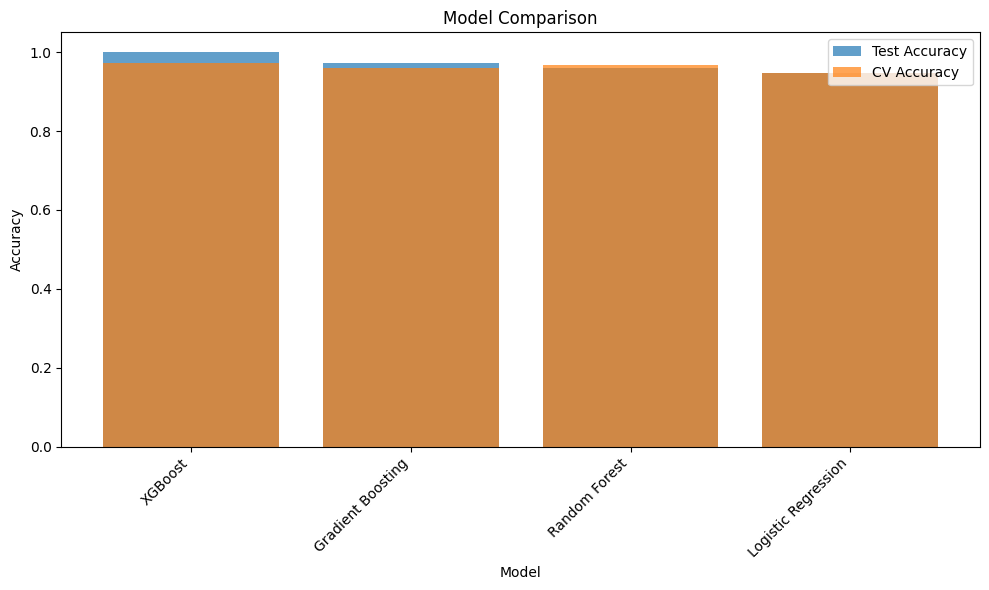

In [ ]:
#compare models
print("MODEL COMPARISON")

# Create comparison dataframe table using pandas
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Test Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'CV Accuracy': [results[m]['cv_mean'] for m in results.keys()],
    'CV Std': [results[m]['cv_std'] for m in results.keys()]
})

comparison_df = comparison_df.sort_values('Test Accuracy', ascending=False)
print("\n", comparison_df.to_string(index=False))

# Visualize comparison
plt.figure(figsize=(10, 6))
x_pos = np.arange(len(comparison_df))
plt.bar(x_pos, comparison_df['Test Accuracy'], alpha=0.7, label='Test Accuracy')
plt.bar(x_pos, comparison_df['CV Accuracy'], alpha=0.7, label='CV Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.xticks(x_pos, comparison_df['Model'], rotation=45, ha='right')#see x axis ha =horizontal alignment
plt.legend()#box on the graph blue and orange info
plt.tight_layout()#makes sure that they wont align with each other
plt.show()


BEST MODEL: XGBoost
Accuracy: 1.0000


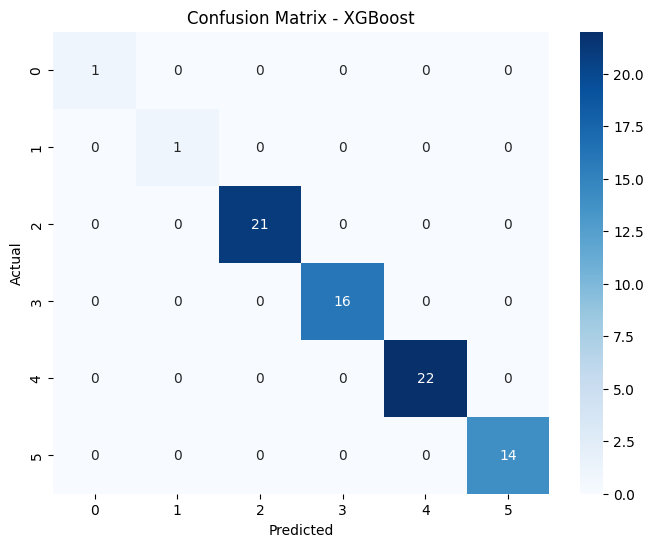


Top 10 Most Important Features:
                Feature  Importance
           Stress Level    0.270089
         Sleep Duration    0.253974
              Person ID    0.142074
            Daily Steps    0.105826
             Occupation    0.061351
             Heart Rate    0.047546
         Blood Pressure    0.041451
Physical Activity Level    0.033308
           BMI Category    0.024377
         Sleep Disorder    0.018949


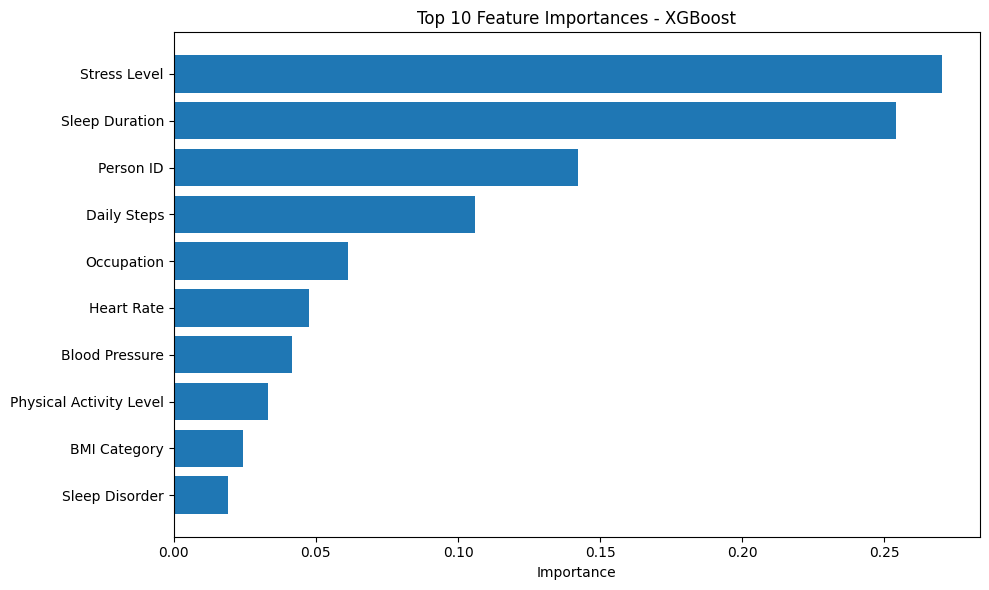

In [ ]:
#select best model and analyse
best_model_name = comparison_df.iloc[0]['Model']#comparision df contains all metrics for all trained models and iloc selects the frst row which should be best model
best_model = results[best_model_name]['model']
best_predictions = results[best_model_name]['predictions']

print(f"BEST MODEL: {best_model_name}")
print(f"Accuracy: {results[best_model_name]['accuracy']:.4f}")


# Confusion Matrix
cm = confusion_matrix(y_test, best_predictions)#compares actual vs predictes values
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Feature Importance (for tree-based models) = sorted from most imp to least imp
if best_model_name in ['Random Forest', 'XGBoost', 'Gradient Boosting']:
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10).to_string(index=False))

    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    top_features = feature_importance.head(10)
    plt.barh(range(len(top_features)), top_features['Importance'])
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Importance')
    plt.title(f'Top 10 Feature Importances - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [ ]:
#split before train
if best_model_name == 'Logistic Regression':
    scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
else:
    scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')

print("CV Accuracy:", scores)
print("Mean Accuracy:", scores.mean())

CV Accuracy: [0.95       0.98333333 0.96666667 0.98333333 1.        ]
Mean Accuracy: 0.9766666666666666


In [ ]:
# Predict on test set
#calculate metrics
y_pred = best_model.predict(X_test)

# 1 Accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

# 2️ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# 3️ Detailed Classification Report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Accuracy: 0.3466666666666667
Confusion Matrix:
 [[ 0  0  2  0  0  0]
 [ 0  0  1  0  0  0]
 [ 0  0 26  0  0  0]
 [ 0  0 16  0  0  0]
 [ 0  0 18  0  0  0]
 [ 0  0 12  0  0  0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         1
           2       0.35      1.00      0.51        26
           3       0.00      0.00      0.00        16
           4       0.00      0.00      0.00        18
           5       0.00      0.00      0.00        12

    accuracy                           0.35        75
   macro avg       0.06      0.17      0.09        75
weighted avg       0.12      0.35      0.18        75



In [ ]:
#better the accuracy
#1.reduce classes
def sleep_label(x):
    if x <= 4:
        return "Poor"
    elif x <= 6:
        return "Average"
    else:
        return "Good"

y_new = df['Quality of Sleep'].apply(sleep_label)
#2.include important features
features = [
    'Sleep Duration',
    'Physical Activity Level',
    'Stress Level',
    'Heart Rate',
    'Daily Steps',
    'BMI Category',
    'Occupation',
    'Sleep Disorder'
]

X = pd.get_dummies(df[features])



In [ ]:
#cal aggain for better acc
X_train, X_test, y_train, y_test = train_test_split(
    X, y_new, test_size=0.2, random_state=42, stratify=y_new
)

model = RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.9866666666666667
              precision    recall  f1-score   support

     Average       1.00      0.95      0.98        22
        Good       0.98      1.00      0.99        52
        Poor       1.00      1.00      1.00         1

    accuracy                           0.99        75
   macro avg       0.99      0.98      0.99        75
weighted avg       0.99      0.99      0.99        75

[[21  1  0]
 [ 0 52  0]
 [ 0  0  1]]


In [ ]:
import pickle #saves py obj to a file and load them later

# Save the model in this file
with open('best_sleep_quality_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)#store the trained model inside the file

# Save the scaler (if needed) for logistic regression
with open('scaler.pkl', 'wb') as f:#open the file in binary mode
    pickle.dump(scaler, f)

# Save feature names
with open('feature_names.pkl', 'wb') as f:
    pickle.dump(list(X.columns), f)

print("\nModel saved successfully!")
print("Files created:")
print("   best_sleep_quality_model.pkl")
print("   scaler.pkl")
print("  feature_names.pkl")



Model saved successfully!
Files created:
   best_sleep_quality_model.pkl
   scaler.pkl
  feature_names.pkl


In [ ]:
#make pred on new data
print(" Making Predictions")


# Example: Predict on first 5 test samples
sample_data = X_test.head(5)
if best_model_name == 'Logistic Regression':
    sample_data_processed = scaler.transform(sample_data)
    predictions = best_model.predict(sample_data_processed)
else:
    predictions = best_model.predict(sample_data)

print("\nSample Predictions:")
for i, (idx, row) in enumerate(sample_data.iterrows()):
    print(f"Sample {i+1}: Predicted = {predictions[i]}, Actual = {y_test[i]}")



 Making Predictions

Sample Predictions:
Sample 1: Predicted = 5, Actual = 5
Sample 2: Predicted = 2, Actual = 2
Sample 3: Predicted = 4, Actual = 4
Sample 4: Predicted = 2, Actual = 2
Sample 5: Predicted = 4, Actual = 4
